# M3 Metric Analysis

The tabular results of evaluating the M3 metric for extended object counts for the RGPS survey design.  All science cases can be found in the metric_results/ directory.  The goal of this notebook is to explore those results in graphical form. 

In [1]:
from os import path, getcwd
from sys import path as pythonpath
pythonpath.append(path.join(getcwd(), '..'))
from astropy.table import Table, Column, vstack
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import config_utils
import regions
import plot_metric_results
import visualization_utils
import numpy as np
from astropy import units as u 
from mw_plot import MWSkyMap

## Setup

First we need to load some of the configuration information for the metric simulation for future reference.

In [2]:
sim_config = config_utils.read_config(path.join(getcwd(), '..', 'config', 'sim_config.json'))

In [3]:
# Load the survey regions
all_survey_regions = regions.load_regions_from_file(sim_config, path.join(sim_config['root_dir'], 'region_data', 'rgps_survey_regions.json'))

In [4]:
# Load definitions of science cases and extract the set of topical categories
science_cases = config_utils.read_config(path.join(getcwd(), '..', 'config', 'rgps_science_cases.json'))

science_categories = []
for author, info in science_cases.items():
    if info['ready_for_use'] and info['category'] not in science_categories:
        science_categories.append(info['category'])
science_categories

['wide_area',
 'time_domain',
 'SFR',
 'solar_system',
 'high_cadence',
 'globular_clusters',
 'molecular_clouds',
 'AGN',
 'open_clusters',
 'variable_stars',
 'galactic_center',
 'keyholes',
 'stellar_spectra',
 'extinction',
 'novae',
 'ISM',
 'YSO',
 'GW']

## M3 Extended Object Metric

A number of science cases expressed an interest in observing as many targets as possible from a known catalog of objects. There are several examples of these, including Open and Globular Clusters, Star Forming Regions, and Active Galactic Nuclei. The metrics to evaluate these cases are fundamentally the same - calculating the percentage (by area) of the target catalog to receive observations in the requested filters - the code was combined into a single metric which accepts different target catalogs of interest.

It is therefore most relevant to examine the results of this metric for those science cases which cited input target catalogs rather than all of them. These can be found by searching the rgps_science_cases.json file for science cases with flag 'extended_object_catalog' set to true. These include:

* DAmmando - jetted AGN
* Villasenor - Young massive stars in HII regions
* De_Furio - Star Forming Regions
* Globular_clusters
* Open_clusters

Note that not all proposals listing SFRs or clusters are so labeled, since some proposals aim to perform wide-area surveys in order to detect more clusters rather than to cover a catalog of known objects.

In [6]:
# Load the M3 metric results calculated for the entire known catalogs of the different types of object
m3_results_file = path.join(getcwd(), '..', 'metric_results', 'M3_extended_region_count_extended_object_catalog_results.txt')

m3_results = Table.read(m3_results_file, format='ascii')
m3_results.pprint_all()

Survey_strategy Optic    Science_case        Category        M3_%regions     M3_count
--------------- ----- ----------------- ----------------- ------------------ --------
      wide_area  F184          DAmmando               AGN 6.6339066339066335       27
   panchromatic  F184          DAmmando               AGN 0.9828009828009828        4
    time_domain  F184          DAmmando               AGN 0.2457002457002457        1
      wide_area  F062        Villasenor  molecular_clouds                0.0        0
   panchromatic  F062        Villasenor  molecular_clouds  27.27272727272727       12
    time_domain  F062        Villasenor  molecular_clouds 15.909090909090908        7
      wide_area  F129        Villasenor  molecular_clouds  56.81818181818182       25
   panchromatic  F129        Villasenor  molecular_clouds 29.545454545454547       13
    time_domain  F129        Villasenor  molecular_clouds 18.181818181818183        8
      wide_area  F213        Villasenor  molecular_clo

In [7]:
def plot_m3_per_strategy(results, sim_config, survey_name, plot_name): 
    """
    Function to plot metric values for different science use cases for a specific survey design, for multiple filters.

    Input
        selected_results  Table   Metric results table selecting the output for a specific science case only.
    """

    # Select the results for the specified survey strategy
    idx = np.where(results['Survey_strategy'] == survey_name)[0]
    selected_results = results[idx]

    # Create a set of the science cases 
    case_set = list(set(selected_results['Science_case'].data))
    case_set.sort()
    case_labels = []
    exceptions = ['Globular_Clusters', 'Open_Clusters']
    for label in case_set:
        if label in exceptions:
            case_labels.append(label)
        else:
            idx = np.where(selected_results['Science_case'] == label)[0]
            case_labels.append(label + '\n(' + selected_results['Category'].data[idx[0]] + ')')
    xrange = np.arange(0, len(case_set), 1)
    
    # Identify which filters were requested for this science case
    filter_set = list(set(selected_results['Optic'].data))
    filter_set.sort()
    bar_width = 1.0 / (len(filter_set)+2)

    # Plot the metric results 
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))

    dataset = {}
    for j, optic in enumerate(filter_set):

        bar_offset = bar_width * (j - j/len(filter_set))
        
        fdx = selected_results['Optic'] == optic
        metric_filter = selected_results[fdx]
        
        data = []
        for i,case in enumerate(case_set):
            jdx = np.where(metric_filter['Science_case'] == case)[0]
            if len(metric_filter[jdx]) > 0:
                data.append(
                    [
                        i+bar_offset, 
                        metric_filter[jdx]['M3_%regions'][0],
                        metric_filter[jdx]['M3_count'][0]
                    ]
                )

        if len(data) > 0:
            dataset[optic] = np.array(data)
            
    # First y-axis plots the percentage metric
    for optic, data in dataset.items():
        ax.bar(data[:,0], data[:,1], bar_width,
            color=sim_config['PLOT_COLORS'][optic], alpha=0.3,
            linestyle='none', label=optic)

    # Second y-axis plots the count metric
    # Note the second axis can only be twinned after plotting has finished on the first axis, otherwise
    # the second y-axis labels get screwed up
    ax2 = ax.twinx()
    for optic, data in dataset.items():
        ax2.plot(data[:,0], data[:,2], marker=sim_config['PLOT_SYMBOLS'][optic],
            color=sim_config['PLOT_COLORS'][optic],
           linestyle='none', label=optic)
        
    ymin, ymax = ax.get_ylim()
    for x in xrange:
        ax.plot([x,x], [ymin, ymax], color='grey', linestyle='-.', alpha=0.4)
    
    ax.set_xlabel('Science case', fontsize=20)
    ax.set_ylabel('M3 % of regions included (bars)', fontsize=20, color='magenta')
    ax.set_title('M3 target count for ' + survey_name + ' survey', fontsize=20)
    ax.set_xticks(np.arange(0,len(case_set),1) + 0.5)
    ax.set_xticklabels(case_labels, rotation=45.0, horizontalalignment='right', fontsize=20)
    yticks = np.arange(0.0, 120.0, 20.0)
    yticklabels = [str(round(x,0)) for x in yticks]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels, fontsize=20, horizontalalignment='right', color='magenta')
    
    y2min,y2max = ax2.get_ylim()
    
    if y2max <= 10:
        ax2.set_ylim([0, y2max])
        y2min,y2max = ax2.get_ylim()
        yincr = 1
        yticks2 = np.arange(0, int(y2max)+1, yincr)
        yticklabels2 = [str(round(x,0)) for x in yticks2]
        ax2.set_yticks(yticks2)
        ax2.set_yticklabels(yticklabels2, fontsize=20, color='green')
    else: 
        ax2.set_yscale('log')
        y2min,y2max = ax2.get_ylim()
        yticks2 = ax2.get_yticks()
        yticklabels2 = ax2.get_yticklabels()
        ax2.set_yticks(yticks2)
        ax2.set_yticklabels(yticklabels2, fontsize=20, color='green')

    ax2.set_ylabel('M3 count of regions included (points)', fontsize=20, color='green')
    
    ax.legend(fontsize=18, bbox_to_anchor=(1.3, 1))

    plt.tight_layout()
    plt.savefig(path.join(sim_config['root_dir'], 'metric_results', plot_name))

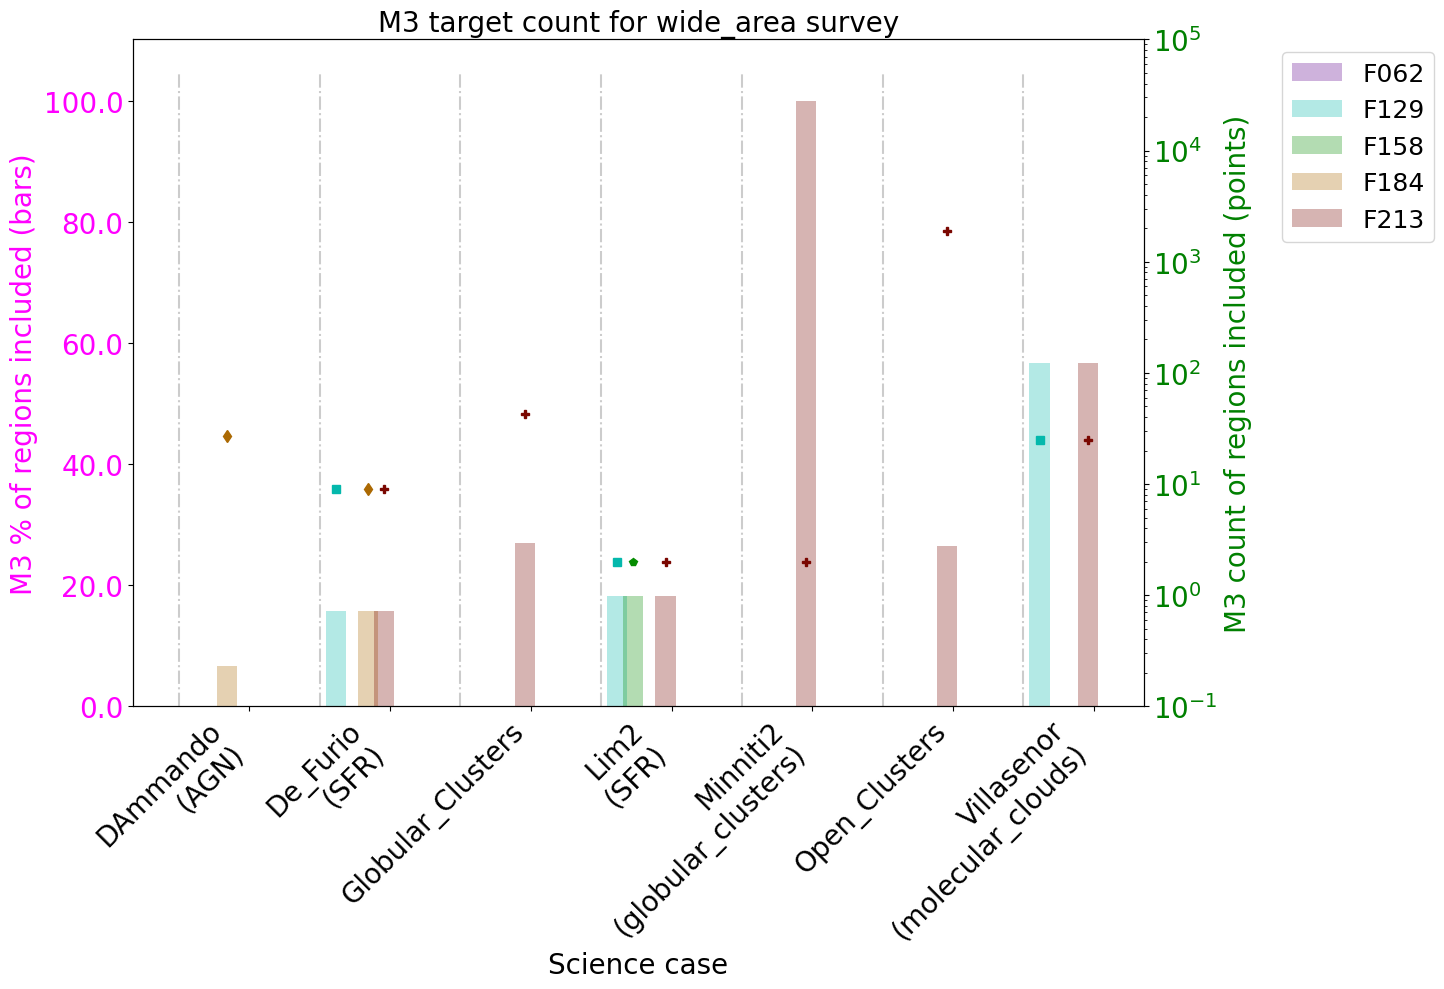

In [8]:
survey_name = 'large_catalog_wide_area'
plot_name = 'm3_results_' + survey_name + '.png'
plot_m3_per_strategy(m3_results, sim_config, 'wide_area', plot_name)

Bearing in mind that this metric returns a percentage of the total sky area subtended by all objects in each catalog, these results cover a wide range.  However, many objects (e.g. SFRs) subtend large areas as seen from Earth, much of which is well outside the Galactic Plane and covered by other Roman surveys.  The percentage coverage for the Globular_Clusters and Open_Clusters catalogs should be interpreted with this in mind, since these include all known objects across the whole sky.  

Instead, some of the other science cases, such as Minniti2, recommended certain high priority clusters, so the coverage statistics in this case is more representative.  

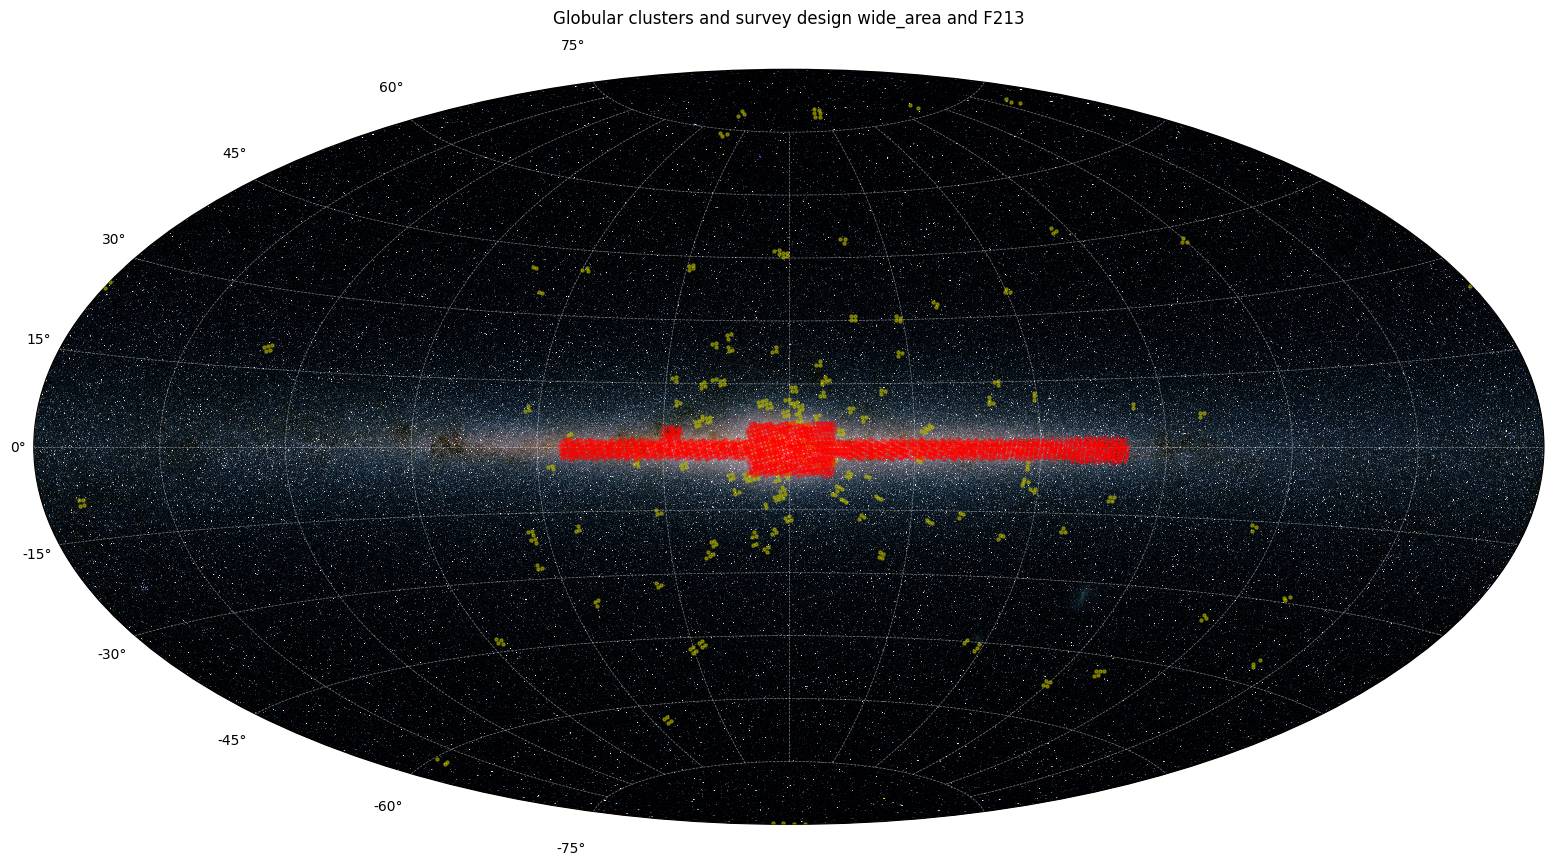

In [9]:
author = 'Globular_Clusters' 
survey_option = 'wide_area' 
optic = 'F213' 

case_set = {author: science_cases[author]}

science_regions_set = regions.build_region_maps(sim_config, case_set)

region_list = []
for author, info in science_regions_set.items():
    for f in sim_config['OPTICAL_COMPONENTS']:
        if f in info.keys():
            for region in info[f]:
                region_list.append(region)
                
r_merge = regions.combine_regions(region_list)

# Plot the combined science regions
plt.close()
mw2 = r_merge.sky_plot(
    title = 'Globular clusters and survey design ' + survey_option + ' and ' + optic, 
    plot_color='y',
    plot_alpha=0.5
)

# Overplot the selected survey design
if len(all_survey_regions[survey_option][optic]) == 0:
    print('WARNING: Survey design ' + survey_option + ' has no region using optic ' + optic)

else:
    for r in all_survey_regions[survey_option][optic]:
        s = r.pixels_to_skycoords()
        mw2.scatter(s.ra.deg*u.deg, s.dec.deg*u.deg, c="r", s=5, alpha=0.4)

plt.tight_layout()
plt.savefig(path.join(sim_config['root_dir'], 'metric_results', 'm3_results_skymap_gcs.png'))

While the data above calculates the metric for entire catalogs of all known objects of a type, many authors requested observations of a specific subset of object types.  These were often selected to, e.g., span a range of ages or metallicities.  So it is valuable to consider how the metric performs for all proposals within the popular categories of clusters and SFRs. 

In [10]:
# Load the M3 metric results calculated for the entire known catalogs of the different types of object
m3_results_file = path.join(getcwd(), '..', 'metric_results', 'M3_extended_region_count_SFR_results.txt')

m3_results = Table.read(m3_results_file, format='ascii')
m3_results.pprint_all()

Survey_strategy Optic    Science_case    Category    M3_%regions     M3_count
--------------- ----- ------------------ -------- ------------------ --------
      wide_area  F106               Zari      SFR              100.0        1
   panchromatic  F106               Zari      SFR              100.0        1
    time_domain  F106               Zari      SFR              100.0        1
      wide_area  F158               Zari      SFR              100.0        1
   panchromatic  F158               Zari      SFR              100.0        1
    time_domain  F158               Zari      SFR              100.0        1
      wide_area  F213               Zari      SFR              100.0        1
   panchromatic  F213               Zari      SFR              100.0        1
    time_domain  F213               Zari      SFR              100.0        1
      wide_area  F213             Werner      SFR               25.0        1
   panchromatic  F213             Werner      SFR               

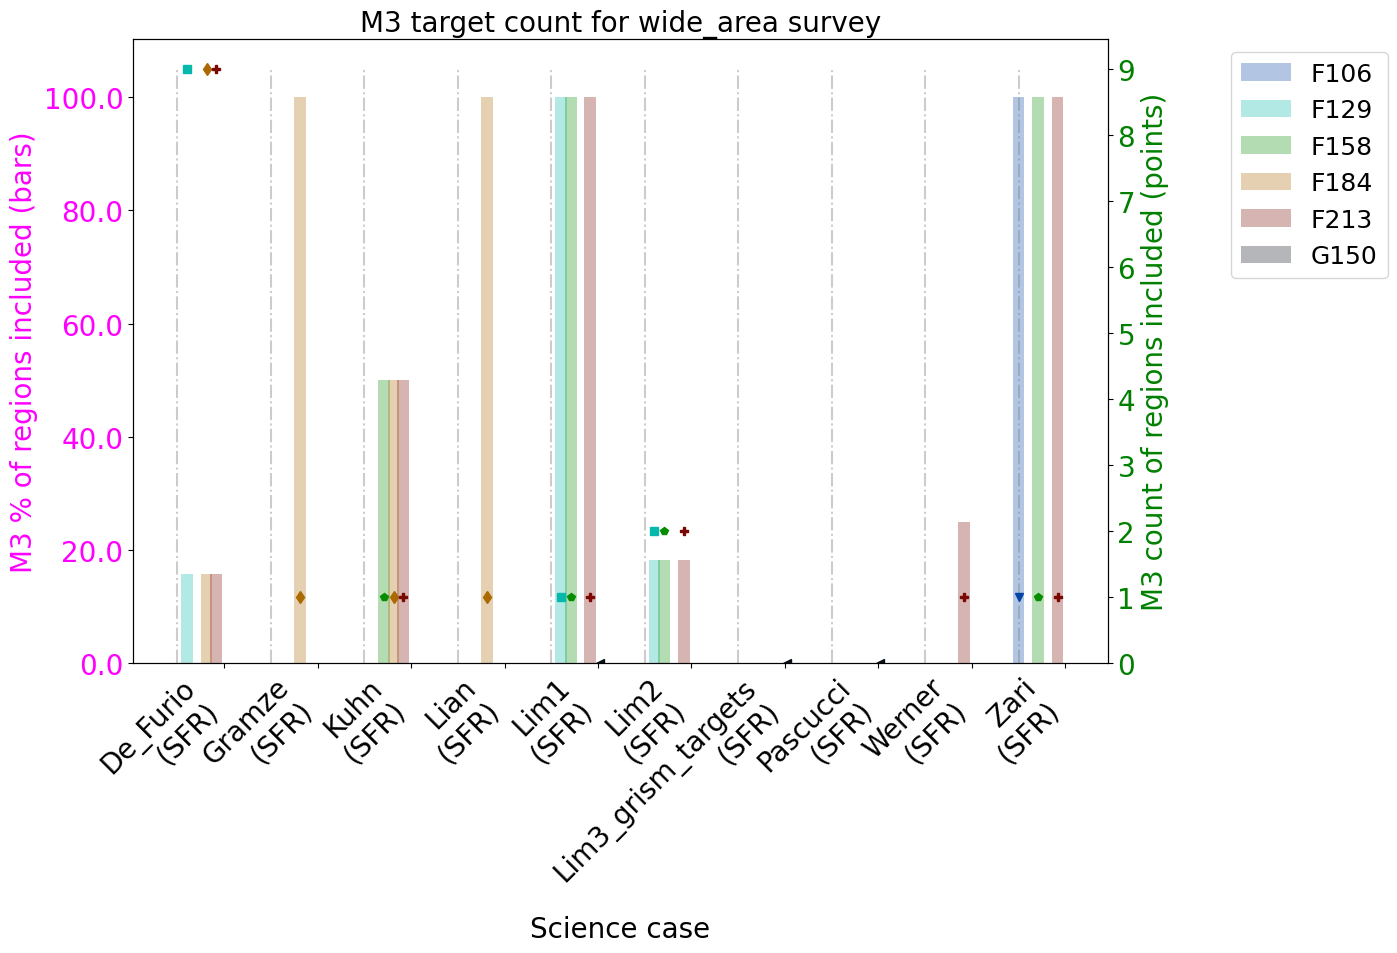

In [11]:
survey_name = 'selected_SFR_wide_area'
plot_name = 'm3_results_' + survey_name + '.png'
plot_m3_per_strategy(m3_results, sim_config, 'wide_area', plot_name)

In [12]:
# Load the M3 metric results calculated for the entire known catalogs of the different types of object
m3_results_file = path.join(getcwd(), '..', 'metric_results', 'M3_extended_region_count_open_clusters_results.txt')

m3_results1 = Table.read(m3_results_file, format='ascii')
m3_results1

Survey_strategy,Optic,Science_case,Category,M3_%regions,M3_count
str12,str4,str13,str13,float64,int64
wide_area,F106,Minniti,open_clusters,0.0,0
panchromatic,F106,Minniti,open_clusters,100.0,1
time_domain,F106,Minniti,open_clusters,100.0,1
wide_area,F158,Minniti,open_clusters,100.0,1
panchromatic,F158,Minniti,open_clusters,100.0,1
time_domain,F158,Minniti,open_clusters,100.0,1
wide_area,F213,Minniti,open_clusters,100.0,1
panchromatic,F213,Minniti,open_clusters,100.0,1
time_domain,F213,Minniti,open_clusters,100.0,1


In [13]:
# Load the M3 metric results calculated for the entire known catalogs of the different types of object
m3_results_file = path.join(getcwd(), '..', 'metric_results', 'M3_extended_region_count_globular_clusters_results.txt')

m3_results2 = Table.read(m3_results_file, format='ascii')
m3_results2

Survey_strategy,Optic,Science_case,Category,M3_%regions,M3_count
str12,str4,str17,str17,float64,int64
wide_area,F062,Lodieu2,globular_clusters,0.0,0
panchromatic,F062,Lodieu2,globular_clusters,0.0,0
time_domain,F062,Lodieu2,globular_clusters,0.0,0
wide_area,F087,Lodieu2,globular_clusters,0.0,0
panchromatic,F087,Lodieu2,globular_clusters,0.0,0
time_domain,F087,Lodieu2,globular_clusters,0.0,0
wide_area,F106,Lodieu2,globular_clusters,0.0,0
panchromatic,F106,Lodieu2,globular_clusters,0.0,0
time_domain,F106,Lodieu2,globular_clusters,0.0,0


In [14]:
m3_results = vstack([m3_results1, m3_results2])

# Exclude rows which represent the full cluster catalogs
rows = []
for entry in m3_results:
    if entry['Science_case'] not in ['Globular_Clusters', 'Open_Clusters']:
        rows.append(entry)

m3_results = Table(rows=rows, names=m3_results.colnames)

m3_results

Survey_strategy,Optic,Science_case,Category,M3_%regions,M3_count
str12,str4,str8,str17,float64,int64
wide_area,F106,Minniti,open_clusters,0.0,0
panchromatic,F106,Minniti,open_clusters,100.0,1
time_domain,F106,Minniti,open_clusters,100.0,1
wide_area,F158,Minniti,open_clusters,100.0,1
panchromatic,F158,Minniti,open_clusters,100.0,1
time_domain,F158,Minniti,open_clusters,100.0,1
wide_area,F213,Minniti,open_clusters,100.0,1
panchromatic,F213,Minniti,open_clusters,100.0,1
time_domain,F213,Minniti,open_clusters,100.0,1


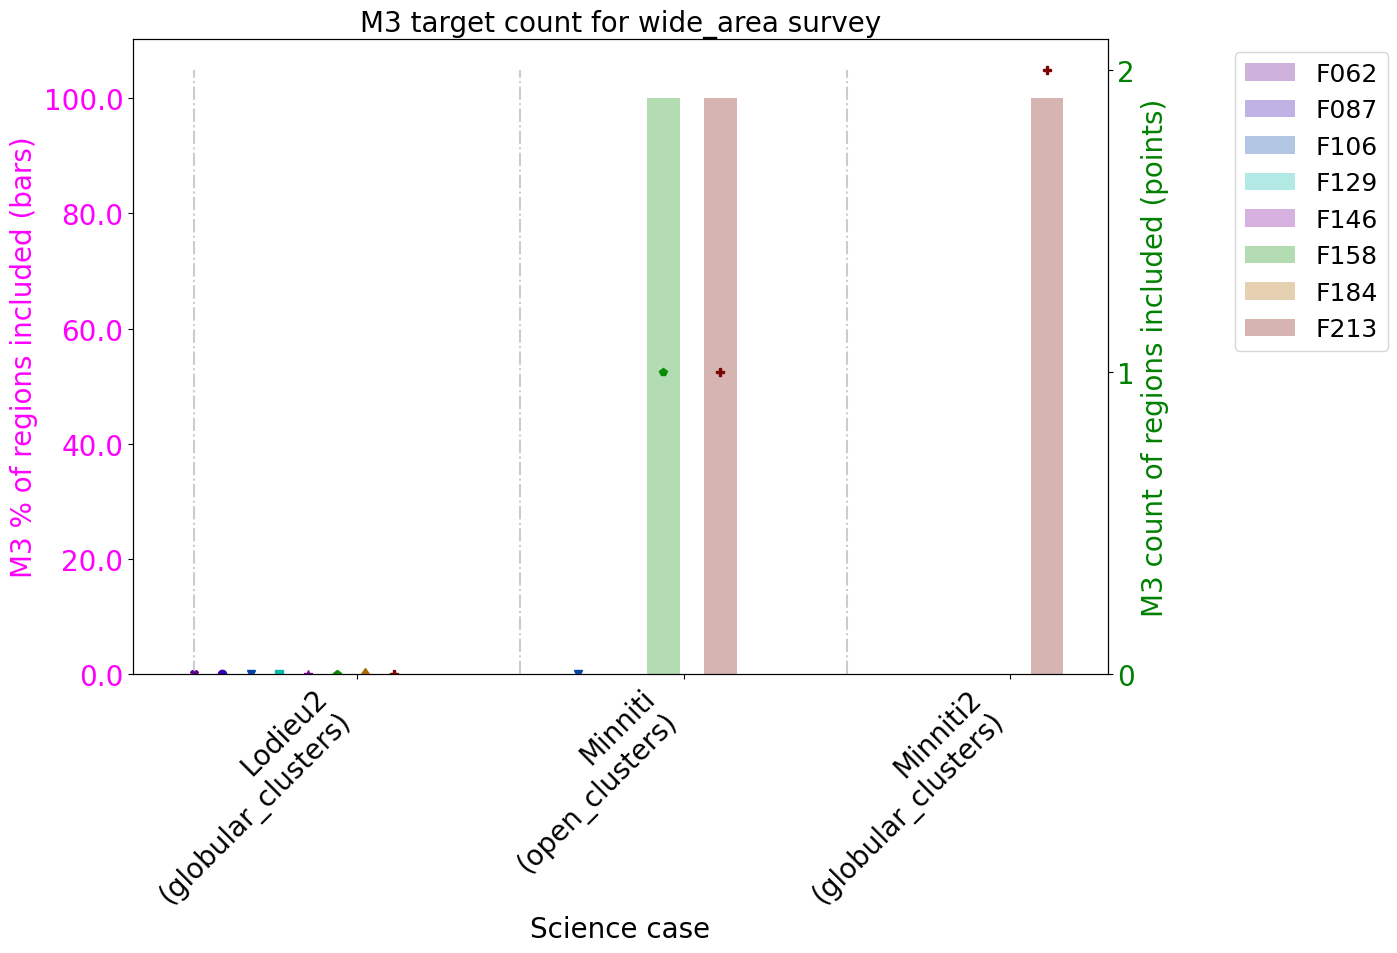

In [15]:
survey_name = 'selected_clusters_wide_area'
plot_name = 'm3_results_' + survey_name + '.png'
plot_m3_per_strategy(m3_results, sim_config, 'wide_area', plot_name)

Some of the science cases that proposed a smaller subset of SFR targets, such as Werner who requested coverage of Orion SFR, Rho Ophiuchi SFR, and Taurus SFR.  Unfortunately the current survey designs provide no coverage of these regions. 